# Keldy: Playground

## Imports & Setup Properties

In [1]:
import os
import sys
import glob
import copy
import itertools

import h5py

import math
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import scipy.integrate


In [2]:
import mpi4py
import mpi4py.MPI

In [3]:
# sys.path

### Plotting

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [5]:
#Plotting Options
markslist='o^v<>dhps*HD'
cmap = plt.get_cmap('plasma')
color_list_limit = 2

def f_colorlist(i, offset = 0, cycle = color_list_limit):
    return cmap(float((i+offset)%cycle) / cycle)

def f_markslist(i, offset = 0, cycle = color_list_limit):
    return markslist[((i+offset)%cycle)]

### Keldy Import

In [6]:
from pytriqs.gf import *
from pytriqs.plot.mpl_interface import oplot,plt

import keldy.impurity_oneband_module as k_imp

## Model g0

In [69]:
anderson_param = {
    "beta": 10000.0, 
    "bias_V" : 0.0,
    "eps_d": 0.0, #"eps_d": 
    "Gamma": 0.25,
    "time_max": 100.0,
    "alpha": -0.0,
    "nr_time_points_gf": int(2*5000-1),#int(1e6),
    "bath_type": "semicircle"
}

In [70]:
g0 = k_imp.G0Model(anderson_param)

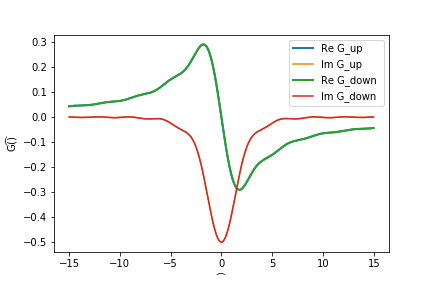

In [71]:
oplot(g0.g0_greater, '-', linewidth=2, x_window=(-15,15)) 

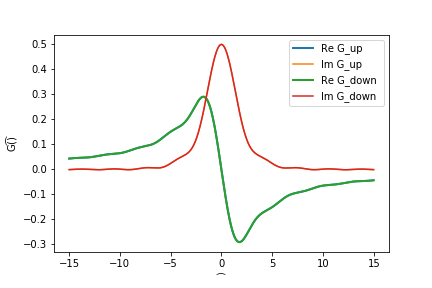

In [72]:
oplot(g0.g0_lesser, '-', linewidth=2, x_window=(-15,15)) 

### Keldysh Adaptor

In [73]:
g0K = k_imp.G0KeldyshContourT(g0)

In [74]:
g0K.model.param_['alpha']

-0.0

In [75]:
# t

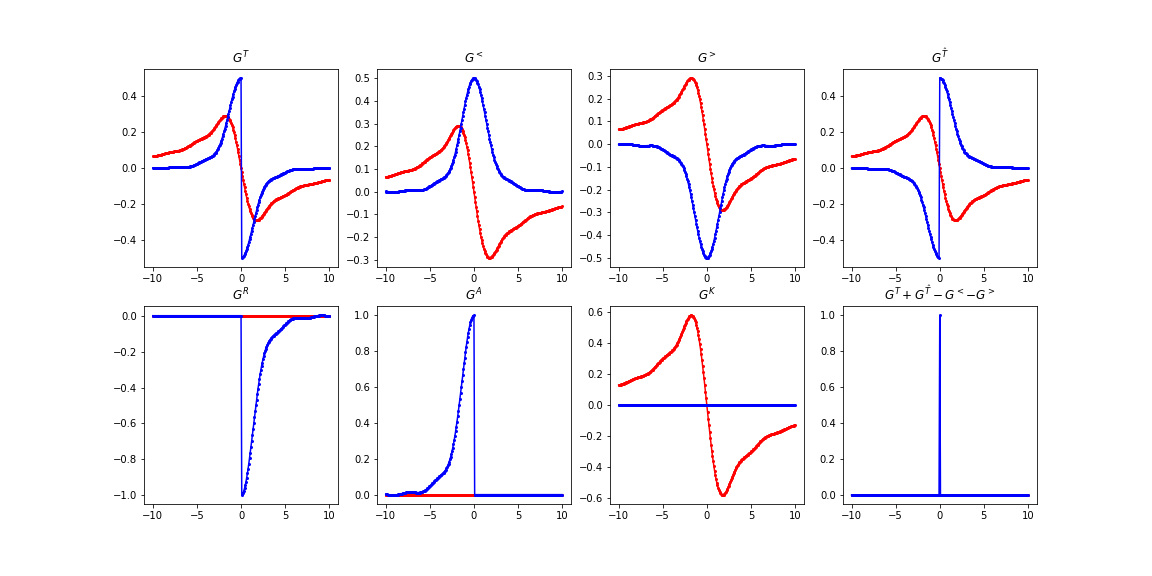

In [76]:
fig = plt.figure(figsize=(16,8))

t = np.linspace(-10,10,251)

g_ff = np.zeros(len(t), dtype='c16')
g_fb = np.zeros(len(t), dtype='c16')
g_bf = np.zeros(len(t), dtype='c16')
g_bb = np.zeros(len(t), dtype='c16')
gR = np.zeros(len(t), dtype='c16')
gA = np.zeros(len(t), dtype='c16')
gK = np.zeros(len(t), dtype='c16')
g_cancel = np.zeros(len(t), dtype='c16')

for i in range(len(t)):
    g_ff[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0, 0), k_imp.GfIndexT(0, 0, 0, 0)) 
    g_fb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0, 0), k_imp.GfIndexT(0, 0, 1, 0)) 
    g_bf[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1, 0), k_imp.GfIndexT(0, 0, 0, 0)) 
    g_bb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1, 0), k_imp.GfIndexT(0, 0, 1, 0)) 

    gR[i]  = g_ff[i] - g_fb[i]
    gA[i]  = g_ff[i] - g_bf[i]
    gK[i]  = g_fb[i] + g_bf[i]
    
    g_cancel[i] = g_ff[i] + g_bb[i] - g_bf[i] - g_fb[i]

plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
for (i_p, (fun, label)) in enumerate(plt_list):
    ax0 = plt.subplot(2,4,i_p + 1)
    ax0.plot(t, fun.real, marker='o', markersize=2, color='red')
    ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
    ax0.set_title(label)
#     ax0.set_scale.
plt.savefig("ph-symm-gf.pdf")
plt.show()

## Measurement

In [77]:
order = 4
computer = k_imp.ComputeChargeQDirect(anderson_param, 10.0, order, 'lorentzian', int(1e6))
N_tot = 0

In [78]:
integrand = computer.get_integrand()
warper = computer.get_warper()

In [79]:
result = []
N_vec = []

currN = 0

In [41]:
for i in range(500):
    step = 1000
    computer.run(step)
    currN += step
    result.append((-1j)*(-1j)**order * computer.reduce_result() )
    N_vec.append(currN)



In [42]:
currN

500000

In [43]:
np.array(result).real[-1]

0.28500610202987026

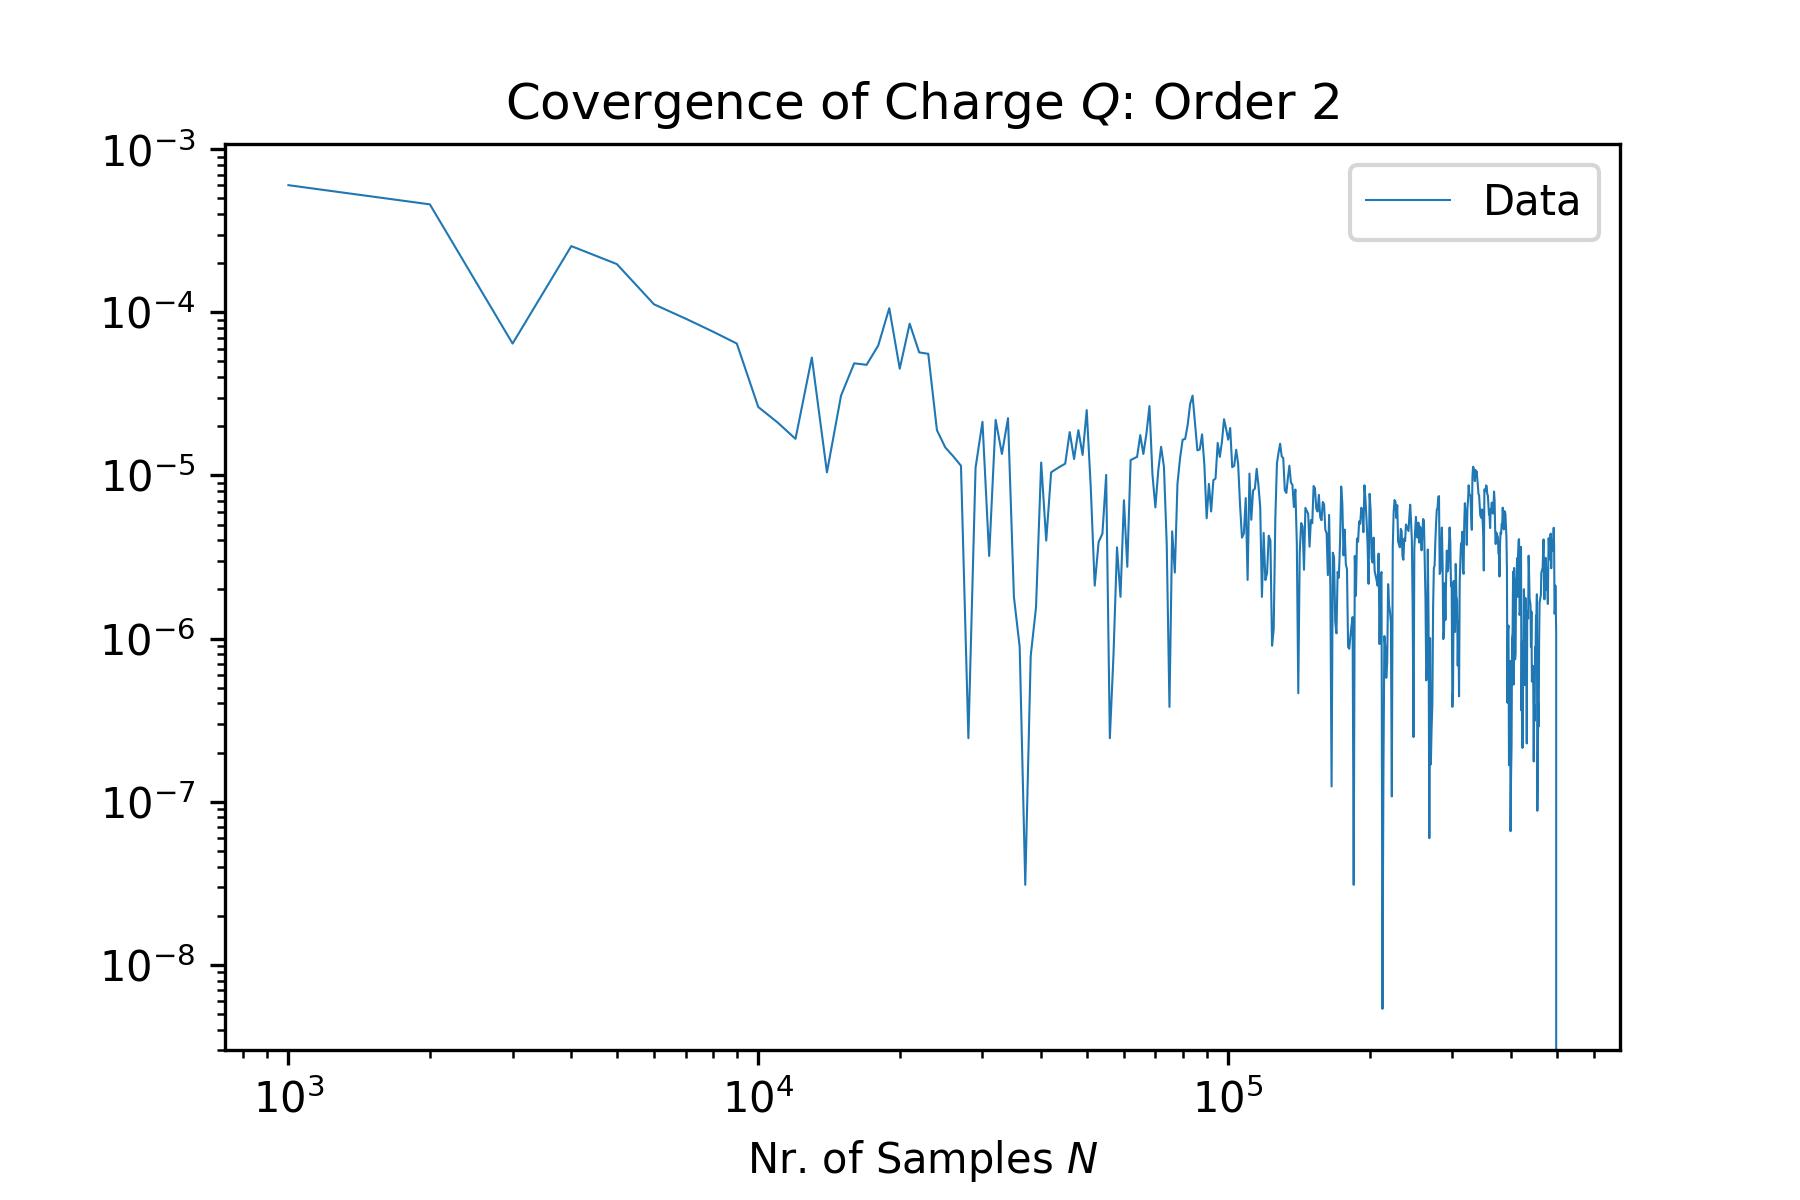

In [44]:
fig = plt.figure(dpi=300)
ax0 = plt.axes()


ax0.plot(N_vec, np.abs(np.array(result).real - np.array(result).real[-1] ), linewidth=0.5, label="Data")

logscale_x = np.array([10**3, 10**7])
logscale_y1 = np.array([10**-3, 10**-7])


# ax0.plot(logscale_x, logscale_y1 * 100, c='red', label="$N^{-1}$")
# ax0.plot(logscale_x, np.sqrt(logscale_y1)  *3, c='k', label="$N^{-1/2}$")

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_title(r"Covergence of Charge $Q$: Order {}".format(order))
ax0.set_xlabel("Nr. of Samples $N$")

ax0.legend()
# plt.tight_layout()
# plt.savefig(save_name + "_krylov_normalization.pdf", dpi=600)
plt.show()
plt.close()

In [43]:
(-1j)*(-1j)**order * computer.reduce_result() 

(0.2850061020283006-8.6582114759719e-13j)

In [44]:
computer.reduce_nr_points_run() 

500000

In [45]:
result_1 = 0.37803751573267336
result_2 = 0.285251918462279

## Compare to Marjan

### Sobol Generator

In [80]:
order_dim = 4

In [81]:
rng = k_imp.Sobol(order_dim, 0)

In [82]:
rng.seed(0)

In [95]:
rng.seed(0)
for i in range(23):
    li = rng()
    ui = warper.ui_from_li(li)
    vi = k_imp.vi_from_ui(t_max, ui)
    
    ui_m = np.array(ProfumaA1_Semicircle)[i,8:12]
    
#     print( li, ui, np.sort(np.array(ProfumaA1_Semicircle)[i,8:12]))
#     print( li, vi, np.array(ProfumaA1_Semicircle)[i,4:8])
    
    integrand_eval = integrand(ui_m)
    print(li, integrand_eval.real - np.array(ProfumaA1_Semicircle)[i,12] *  np.array(ProfumaA1_Semicircle)[i,13])#, integrand_eval.imag - np.array(ProfumaA1_Semicircle)[i,12] *  np.array(ProfumaA1_Semicircle)[i,14])
#     warper_eval = warper.evaluate_warping_function(ui_m)
#     print(li, np.array(ProfumaA1_Semicircle)[i,15] / warper_eval)



    

([0.5, 0.5, 0.5, 0.5], 2.7755575615628914e-17)
([0.75, 0.25, 0.25, 0.25], 1.609823385706477e-15)
([0.25, 0.75, 0.75, 0.75], -1.691355389077387e-17)
([0.375, 0.375, 0.625, 0.875], 6.938893903907228e-17)
([0.875, 0.875, 0.125, 0.375], 7.155734338404329e-17)
([0.625, 0.125, 0.875, 0.625], -1.6705387073656652e-15)
([0.125, 0.625, 0.375, 0.125], 3.469446951953614e-16)
([0.1875, 0.3125, 0.9375, 0.4375], -1.942890293094024e-16)
([0.6875, 0.8125, 0.4375, 0.9375], 0.0)
([0.9375, 0.0625, 0.6875, 0.1875], -2.817841446289826e-16)
([0.4375, 0.5625, 0.1875, 0.6875], 4.163336342344337e-16)
([0.3125, 0.1875, 0.3125, 0.5625], -1.457167719820518e-15)
([0.8125, 0.6875, 0.8125, 0.0625], -2.925177461365891e-16)
([0.5625, 0.4375, 0.0625, 0.8125], 1.5890067039947553e-15)
([0.0625, 0.9375, 0.5625, 0.3125], 4.718447854656915e-16)
([0.09375, 0.46875, 0.46875, 0.65625], 2.706168622523819e-16)
([0.59375, 0.96875, 0.96875, 0.15625], 0.0)
([0.84375, 0.21875, 0.21875, 0.90625], 2.480654570646834e-16)
([0.34375, 0.71

In [42]:
ProfumaA1_Semicircle = np.genfromtxt("/Users/pdumitrescu/Documents/machine-learning-marjan2019/Data/ProfumoMethod/ProfumoA1_DataPoints.dat")

In [47]:
ProfumaA1_Semicircle[1,:]

array([ 7.50000000e-01,  2.50000000e-01,  2.50000000e-01,  2.50000000e-01,
        2.14271531e+00,  2.94086787e-01,  2.94086787e-01,  2.94086787e-01,
        6.97502433e+00,  9.11773964e+00,  9.41182643e+00,  9.70591321e+00,
        1.00000000e+00, -7.38298311e-15, -7.73698932e-03,  3.15617710e-02])

## Plot Integrand

In [29]:
t_max = 10.0

### Order 1

In [30]:
t = np.linspace(0.0,10.0,251)
t_list = [list([t0]) for t0 in t]
W_order1 = np.array(map(warper.evaluate_warping_function, t_list))

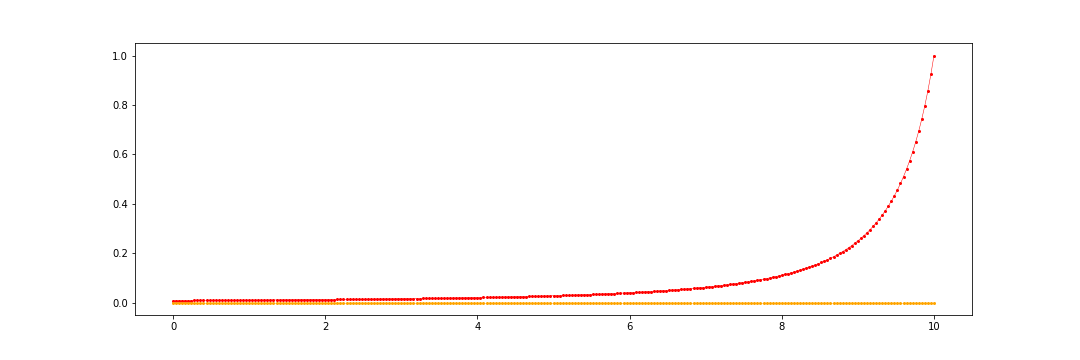

In [31]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, W_order1.real, marker='o', markersize=2, linewidth=0.5, color='red')
ax0.plot(t, W_order1.imag, marker='o', markersize=2, linewidth=0.5, color='orange')
plt.show()

### Order 2

In [32]:
u_list_p = []
u_list = []
v_list = []

nr_sample_edge = 250
delta_t = 10.0 / nr_sample_edge

for i_t1 in range(nr_sample_edge + 1):
    for i_t2 in range(nr_sample_edge + 1):
        times = np.array([delta_t * i_t1, delta_t * i_t2])
        times = np.sort(times)[::-1]
        u_list.append(times)
        v_list.append(k_imp.vi_from_ui(t_max, times))

g_order2_i = np.array(map(integrand, u_list))
g_order2_w = np.array(map(warper.evaluate_warping_function, u_list))

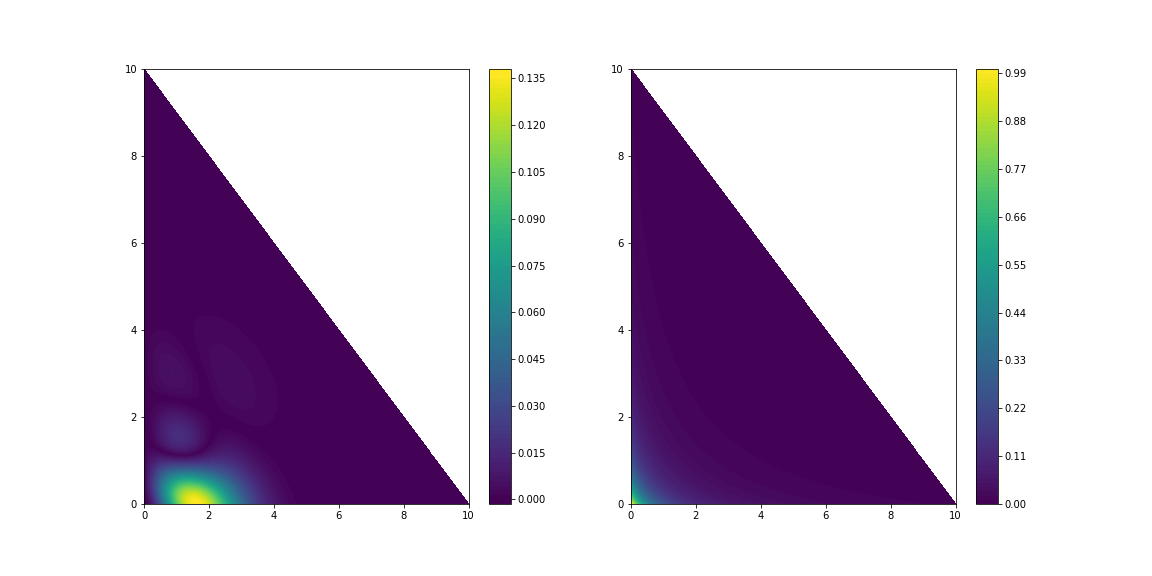

In [33]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=(16,8))

x = np.array(v_list)[:,0]
y = np.array(v_list)[:,1]
z = np.abs(g_order2_i)

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.subplot(1,2,1)
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar

x = np.array(v_list)[:,0]
y = np.array(v_list)[:,1]
z = np.abs(g_order2_w)

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.subplot(1,2,2)
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar


plt.show()

In [46]:
# t = np.linspace(0.0,10.0,251)
# t_list = [list([t0, t0]) for t0 in t]

# W_order2_diag = np.array(map(computer.integrand, t_list))

# fig = plt.figure(figsize=(15,5))
# ax0 = plt.subplot(1,1,1)
# ax0.plot(t, W_order2_diag.real, marker='o', markersize=2, linewidth=0.5, color='red')
# ax0.plot(t, W_order2_diag.imag, marker='o', markersize=2, linewidth=0.5, color='orange')
# plt.show()

## SciPy Integral

In [47]:
def lim0():
    return [0, 10.0]

def lim1(t1):
    return [0, t1]

def lim2(t1, t2):
    return [0, t2]

result_1_sp = sp.integrate.nquad(lambda x: computer.integrand([x]).real, [lim0], opts={'limit': 1000}, full_output=True)
result_2_sp = sp.integrate.nquad(lambda x, y: computer.integrand([x, y]).imag, [lim1, lim0], opts={'limit': 1000}, full_output=True)
# result_3_sp = sp.integrate.nquad(lambda x, y, z: my_integrand([x, y, z]).real, [lim2, lim1, lim0], opts={'limit': 50}, full_output=True)


In [48]:
print "Order 1:", result_1_sp
print "Order 2:", result_2_sp

Order 1: (-0.18157328685641913, 2.3575981097923027e-09, {'neval': 63})
Order 2: (1.6315647010411563, 1.4869438519640528e-08, {'neval': 4893})


In [49]:
print result_1 + result_1_sp[0]
print result_2 + result_2_sp[0]

NameError: name 'result_1' is not defined

In [50]:
## Cuba Evaluation

### Cubature Evaulation

In [52]:
from cubature import cubature# S.Johnson package # https://github.com/saullocastro/cubature

In [185]:
#Order 1

def order_1_vectorize(t):
    t_list = [list(t0) for t0 in t]
    out = np.transpose(np.array([map(computer.integrand, t_list)]))
    return np.real(out[:,0])

xmin = [ 0.0]
xmax = [10.0 - 1e-10]
result_1_cub_val, result_1_cub_err = cubature(order_1_vectorize, 1, 1, xmin, xmax, vectorized=True, abserr=1e-10, relerr=1e-10, adaptive='p')
print result_1_cub_val[0], ",", result_1_cub_err[0]

-0.3780374601590787 , 1.0386247417670802e-11


In [186]:
print result_1 + result_1_cub_val[0]

5.5573594670565996e-08


In [ ]:
def my_integrand_order2_scaled(t):
    return t[0] * computer.integrand([t[0], t[0] * t[1]])


def order_2_scalar(t):
    t_list = [list(t0) for t0 in list(t)]
    out = np.imag(t[:, 0] * np.transpose(np.array([map(my_integrand_order2_scaled, t_list)])))
    return out[:,0]
#     return np.imag(t[0] * my_integrand([t[0], t[0] * t[1]]))

xmin = [0.0, 0.0]
xmax = [10.0, 1.0]
result_2_cub_val, result_2_cub_err = cubature(order_2_scalar, 2, 1, xmin, xmax, vectorized=True, abserr=1e-4, relerr=1e-4, adaptive='p')
print result_2_cub_val[0], ",", result_2_cub_err[0]

In [ ]:
print result_2 + result_2_cub_val[0]

In [48]:
def integrand_rectangle(x_array):
    return 1.

def integrand_rectangle_v(x_array):
    return np.ones_like(x_array[:, 0])

def integrand_circle(x_array):
    return x_array[0]

def integrand_circle_v(x_array):
    return x_array[:, 0]

def exact_rectangle(a, b):
    return a*b

def exact_circle(r):
    return math.pi*r**2

# rectangle
print('_________________')
print('')
print('Rectangle')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# rectangle (vectorized)
print('_________________')
print('')
print('Rectangle (vectorized)')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# circle
print('_________________')
print('')
print('Circle')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')
# circle (vectorized)
print('_________________')
print('')
print('Circle (vectorized)')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')


_________________

Rectangle


NameError: name 'cubature' is not defined

## Factorial vs Power Nr of Operations

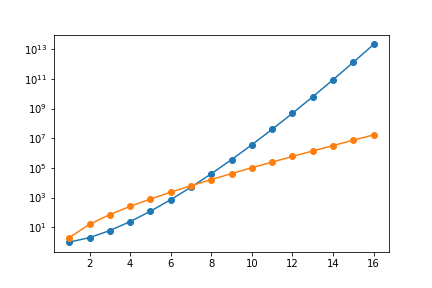

In [17]:
## Figure out exact FLOP scaling

x = np.linspace(1,16,16, dtype=int)
y_fac = map(np.math.factorial, x)#.linspace(1,10,10, dtype=int)
y_det = np.power(2, x) * np.square(x)

plt.plot(x, y_fac, marker='o')
plt.plot(x, y_det,  marker='o')
plt.yscale('log')

In [134]:
1+1

2